[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/keras_nlp.ipynb)

In [230]:
!ps -ef | grep python

import tensorflow as tf
tf.test.gpu_device_name()


root        73    67  0 07:41 ?        00:01:14 /usr/bin/python2 /usr/local/bin/jupyter-notebook -y --no-browser --log-level=DEBUG --debug --NotebookApp.allow_origin="*" --NotebookApp.log_format="%(message)s" --NotebookApp.disable_check_xsrf=True --NotebookApp.token= --Session.key="" --Session.keyfile="" --ContentsManager.untitled_directory="Untitled Folder" --ContentsManager.untitled_file="Untitled File" --ContentsManager.untitled_notebook="Untitled Notebook" --KernelManager.autorestart=True --MultiKernelManager.default_kernel_name="python2" --ip="127.0.0.1" --port=9000 --port-retries=0 --notebook-dir="/content" --NotebookApp.base_url=/tun/m/gpu-2g6xqzfzg6n8d/
root        81    73 41 07:41 ?        02:01:48 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-06ba2743-ed0a-4ddb-a2db-40574824e7b4.json
root      4882    81 99 12:32 pts/0    00:00:01 /bin/sh -c ps -ef | grep python
root      4884  4882  0 12:32 pts/0    00:00:00 grep python


'/device:GPU:0'

>>[Keras accuracy/performace limitations](#scrollTo=vR_wGTR6szDb)

>>[Pretraining autoencoder or LM will surely help.](#scrollTo=vR_wGTR6szDb)

>>>[CuDNNLSTM vs LSTM](#scrollTo=vR_wGTR6szDb)

>>>[Tip to self:](#scrollTo=vR_wGTR6szDb)

>>>[For David: example of how to clone, then use from github](#scrollTo=OrKzdh71sBKm)

>[Dataset](#scrollTo=wwc6_EHFD_Ir)

>[Model defintion](#scrollTo=BWVEcaeF6DBR)

>>[classifier](#scrollTo=VTobPYftYvQC)

>>[adverserial model](#scrollTo=9TBO_5dXv40K)

>[TRAINING](#scrollTo=9s0-8EJi6AG1)

>[Error analysis](#scrollTo=XvIkFOWy55ov)

>>[Error of style disc.](#scrollTo=8QaOXXjUAwVH)



## Keras accuracy/performace limitations
 
# Performace caution :
G training epoc (250x64 rows) 

type|RNN|bidi?|time
--|--
CPU|LSTM|Y| 15 min|
GPU|LSTM|Y| 75s| (slower but more-accurate)
GPU|CuDNNLSTM|Y| 42s
GPU|CuDNNLSTM|N| 35s






## Pretraining autoencoder or LM will surely help.

see late review here: https://thegradient.pub/author/sebastian
and autoencoder (which is less recommended than LM here: "Semi-supervised Sequence Learning" 2015. They use one RNN for both encoder and decoder)


###   LSTM 
* CuDNNLSTM trains on GPU , but does not support the attributes: dropout,recurrent_dropout,which are the STOA regulaizers. This is cuda problem, and even native TF does not support it
Hard to compare only that. all G (with dense and more...) takes 35s on GPU. on CPU ???
* Make LSTM deep instead of bigger for linear instead of quadratic growth in compuation. when doing so, add skip connection to 2nd/3rd/... layers
* large vocab size means huge softmax, means slow runtime. to optimize training NCE loss replaces softmax on train-time (TF only)

### Tip to self:
* manually check loss value on one sample (predict vs gt). From doing this, I saw <s> was not given one-hot-value

### For David: example of how to clone, then use from github
```python
#!rm -r language-style-transfer  #remove previous github copy if needed
!git clone https://github.com/assaflehr/language-style-transfer.git
#we rename to as lang_transfer will be the package name
!mv language-style-transfer/code language-style-transfer/lang_transfer

# Add the local_modules directory to the set of paths Python uses to look for imports.
import sys
sys.path.append('language-style-transfer')

import lang_transfer   #your code here!!!
```

In [0]:
# adaptation of: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# first Dataset class to load bible-data
# then copy of the model, but working with words instead of chars





# Some params

In [0]:
embedding_dim=300 #100-300 good numbers

# for hidden unit of LSTM. Increasing it increase the model strength (and compuation time).
# increasing should increase fit to train (and when using stronger reguralization/dropout even val)
latent_dim = 512 

bidi_encoder=True

cuddlstm=True  
 
# LSTM dropouts, one of the best ways to fight overfiltting. ragnge 0-0.5++ (0 means no dropout)
# Increase it to reduce diff between train and val
en_lstm_dropout=0.3          
en_lstm_recurent_dropout=0.3 #only relevant if NOT cuddlstm.
de_lstm_dropout=0.0          #only relevant if NOT cuddlstm.
de_lstm_recurent_dropout=0.0 #only relevant if NOT cuddlstm

batch_size=64



# Dataset

In [232]:
## NLP preprocessing for text
# has few parts:
# 1. load zip files and then use glob to filter part of them (data/*/*.txt)
# 2. parse each row into (x,y) by passing a parser method. it can be simple as lambda line:line:x, or if you use tab delimited lambda line: line.split(',')[4]
# 3. tokenize - split by spaces, but also by ., and be smart about it.  ('...' should be one token , "ai'nt" one token. then; should be two 'token' and ';')
#    you should also build vocabulary, keep X words and throw away rare ones, they will be replaced by <oov> flag.
# 4. transform text to sequences for the result. for words there are usually two different types: ['s>','hello', 'world'] -> [0,5,6] but there is also 
#     a one-hot-econding version where 5 is actaully a vector of size voc-length full of zeros, with 5th index==1.
#    The one-hot ecoding is used as output for text-generation and has a HUGE MEMORY requirement.  100K sentences of size 20 words need 2M floats = 8MB
#    But for the one-hot-encoding multiply this by vocab-size. for char-encoding it's ~30 , for good vocab of 10K words, we need 80GB(!)
#    The simple, and only , way to solve this , is to never keep one-hot-encoding in memory, just use a generator to make it one-hot in runtime



from __future__ import print_function

import numpy as np
import os
import glob
import csv, json
from collections import namedtuple
from zipfile import ZipFile
from os.path import expanduser, exists
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer



TVT = namedtuple('TVT',['train','val','test'])

class Dataset:
  #Dataset for COPY encoder-decoder
  # to David: generator x,y where x1 is encoder_input is batch_size,max-words of type integer. (hello word <e> )   [x] (64,10)
  #                               x2 is decoder_input is batch,max-words of type integer  ( <s>  hello word)  [x]      (64,10)
  #                               y1             batch,max-words,one-hot-encoding (offset one: hello world <end>) (64,10,10000)
  #                               y_style:           batch,one-hot-of-style                                       (64,2)
  #                                          shape: (64,10)  batch_size=64 ,max_words=10 , vocab_size= 10000  style_vocab=2/5
  # tokenizer is currently very bad. replace it
  # vocabulary (training-only) , don't use 666 , use large number (10K?)
  # Generator : iteration result ([x1,x2],[y1,y_style])
  
  # for auto-encoder pre-training without style  ([x1,x2],y1)  with no y_style
  
  
  def __init__(self,unique_name,url,extract,cache_dir,pattern,skip_first,row_parser,validation_pattern=0.1,test_pattern=0.1):
    '''
    unique_name will be used for the dataset source(or zip) file. 
    pattern need to include path inside zip (including zip root)
    extract - is it zipped/tarred or not
    cache_dir - under which the files be downloaded <cache_dir>/datasets/<unique_name>
    pattern - glob will be done to choose only those files ,for example data*.txt. This should incldude both train and test
    validation - subset glob pattern to use. If it's a float like 0.1, use it as split of one file
    test - see above
    '''
    if not extract and pattern:
      raise ValueError('pattern must be empty if extract=False chooses a subset of the files (data/*.txt). but you downloaded only one file')

    if not os.path.exists(cache_dir):
       os.makedirs(cache_dir)

    fpath=get_file(unique_name, url,extract=True, cache_dir=cache_dir)
    print ('fpath',fpath)
    files = [fpath] if not pattern else glob.glob(f'{cache_dir}/datasets/{pattern}')

    train,val,test=[],[],[]
    for f in files:
      lines = [row_parser(f,line.rstrip()) for line in open(f,encoding="latin-1").readlines()] 
      print ('max lines in file f',len(lines))
      lines = lines[1 if skip_first else 0:][:30000]
      print ('HARDCODED MAX LINES = 30000')
      
      print (files,'#lines',len(lines),'first 3 lines')
      print (lines[0],'\n',lines[1],'\n',lines[2])
      
      if isinstance(validation_pattern,float) and isinstance(test_pattern,float):
        test_count = int(len(lines)*(1-validation_pattern))
        val_count =  int(len(lines)*(1-test_pattern-validation_pattern))
        print ('(val_count,test_count)',val_count,test_count)
        train+= lines[:val_count]
        val+=   lines[val_count:test_count]
        test+=  lines[test_count:]
        
    self.tvt_lines = TVT(train, val, test)
    print ('train:',len(self.tvt_lines.train),'val',len(self.tvt_lines.val),'test',len(self.tvt_lines.test))
    self.parsed= self.tvt_lines
  
  
  def fit(self):
    """ the current implementation is quite bad, hello world! will be 2 tokens world! is the second. 
    """
    print ('limiting num_words in Tokenizer due to MEMORY BOUNDS')  #num_words =100*1000

    
    # I use here tokenizer only to count freq. of words, then manually choose most freq. and manually split
    # this is bad. There are better ways to do it (probably library/code which do it in one line)
    print ('\nREPLACE ME . BAD TOKENIZER!!!')
    self.tokenizer = Tokenizer(num_words=100000, filters='', lower=False, split=' ', char_level=False, oov_token='<oov>')
    
    # self.parsed.train is a list , each value is tuple text_string,file_name
    self.tokenizer.fit_on_texts([x for x,style in self.parsed.train])
    self.styles = set([style for x,style in self.parsed.train])
    print ('styles',self.styles)
    self.style2index = {style:i for i,style in enumerate(self.styles)}
    self.index2style = {index:style for style,index in self.style2index.items() }
    print (self.style2index,self.index2style)
    
    #print ('\n word_index',len(self.tokenizer.word_index),'<oov>',self.tokenizer.word_index['<oov>'])
    print ('common',list(self.tokenizer.word_index.items())[:15])
    print ('uncommon',list(self.tokenizer.word_index.items())[-15:])
  
    
    num_words= 10000
    print ('CAPPING. keeping ',num_words,'of',len(self.tokenizer.word_index))
    
    num_words= min(num_words,len(self.styles)+1+len(self.tokenizer.word_index))
    print (num_words,num_words,num_words)    
    word2index = dict(list(self.tokenizer.word_index.items())[:num_words-len(self.styles)-2])
    word2index['<s>']=0  #keras tokenizer keeps 0 unused
    for i,style in enumerate(self.styles):
      word2index[style]=num_words-1-len(self.styles)+i  #if num_words=100 . [96,97,98] 
    word2index['<oov>']=num_words-1                     #<oov> is [99]
    print ('word2index',len(word2index))
    
    #FOR NOW the start and end are both ZERO. maybe not good???
    
    num_encoder_tokens = num_decoder_tokens= num_words # len(self.tokenizer.word_index)
    self.word2index = word2index
    self.index2word = {index:word for (word,index) in self.word2index.items()}
    self.MAX_SEQUENCE_LENGTH=20  #100
    
    verbose=5
    result = []
    for rows in self.parsed:

      encoder_input_data  = np.zeros( (len(rows), self.MAX_SEQUENCE_LENGTH),    dtype='float32')
      decoder_input_data  = np.zeros( (len(rows), self.MAX_SEQUENCE_LENGTH),    dtype='float32') # shifted by 1
      decoder_target_data = None #np.zeros((len(rows),  self.MAX_SEQUENCE_LENGTH, num_decoder_tokens),    dtype='float32')
      style_data          = np.zeros((len(rows),  len(self.styles)),    dtype='float32') #one-hot
      
      #input to decoder   <s> hello world
      #target of decoder: hello world <s>
      
      for i, (input_text,style) in enumerate(rows):
        input_text = input_text.split(' ') #BUG: we need to use tokenizer here!!!!
        #pad with end token  hello world <end> <end> <end>
        end_token='<s>'
        input_text += [end_token for _ in range(self.MAX_SEQUENCE_LENGTH - len(input_text)+1)]
        if verbose:
          print ('input_text',input_text)
          verbose-=1
        # out : hello  world  <end>  (MAX_SEQUENCE_LENGTH=2)  <-encoder_input+ decoder_output(but one-hot)
        #
        # in: : <s>   hello   world  <- decoder-input
         
        for t, word in enumerate(([style]+input_text)[:self.MAX_SEQUENCE_LENGTH]):
            one_hot = word2index['<oov>'] if word not in word2index else word2index[word]
            decoder_input_data[i, t ] = one_hot
            
        for t,word in enumerate(input_text[:self.MAX_SEQUENCE_LENGTH]):  #last must be <end>=<s> token
            one_hot = word2index['<oov>'] if word not in word2index else word2index[word]
            encoder_input_data[i,t]=one_hot
            #decoder_target_data[i, t, one_hot] = 1. 
            
        style_data[i,self.style2index[style]]= 1
        
      #print (decoder_target_data.sum(),len(rows)*self.MAX_SEQUENCE_LENGTH)
      #assert int(decoder_target_data.sum())==len(rows)*self.MAX_SEQUENCE_LENGTH #one-hot-encoding must always include one
      
      result.append( (encoder_input_data,decoder_input_data,decoder_target_data,style_data))

    self.result= TVT(*result)

  def one_x_as_text(self,x):
    """ 1x20 or 20 input"""
    if len(x.shape)==2: 
      assert x.shape[0] ==1  #can only work on batch of 1
      x= x[0]
    return ' '.join([self.index2word[index] for index in x])

  def one_y_as_text(self,y):
    """ 1x20x2000 or 20x2000 input, in case of first will work on y[0]"""
    if len(y.shape)==3: 
      assert y.shape[0] ==1  #can only work on batch of 1
      y=y[0]
      
    best_token = np.argmax(y,1)
    return ' '.join([self.index2word[index] for index in best_token])

  
cache_dir='cache' 
#dataset('quora_dups','http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv',False,cache_dir) 
#dataset('bible4','https://codeload.github.com/keithecarlson/Zero-Shot-Style-Transfer/zip/master',extract=True,cache_dir=cache_dir
#       pattern=('Zero-Shot-Style-Transfer-master/Data/Bibles/ASV/*/*.txt','Zero-Shot-Style-Transfer-master/Data/Bibles/BBE/*/*.txt')

#x,y,z,t,and good, will happen , here
row_parser= lambda file_name,line: (','.join(line.split(',')[4:]),
                                    file_name.split('/')[-1]) #map x to x,style_file
dataset = Dataset('bible_csv','https://codeload.github.com/ashual/style-transfer/zip/master',extract=True,cache_dir=cache_dir,
                  
                  pattern='style-transfer-master/datasets/bible-corpus/t_[yb]*.csv',skip_first=True,row_parser=row_parser)    #kbd
dataset.fit()        
x_train, x_train_d, y_train,style_train = dataset.result.train
x_val, x_val_d,y_val ,style_val= dataset.result.val
x_test,x_test_d,y_test ,style_test= dataset.result.test

print ('train',x_train.shape,x_train_d.shape,y_train,style_train.shape)
print('val',x_val.shape)
print ('train in MB x,y',x_train.nbytes/1e6)


#,t_bbe,BBE,english,Bible in Basic English,,http://en.wikipedia.org/wiki/Bible_in_Basic_English,,Public Domain,
                  #,t_dby,DARBY,english,Darby English Bible,,http://en.wikipedia.org/wiki/Darby_Bible,,Public Domain,
                  #,t_kjv,KJV,english,King James Version,,http://en.wikipedia.org/wiki/King_James_Version,,Public Domain,


fpath cache/datasets/bible_csv
max lines in file f 31104
HARDCODED MAX LINES = 30000
['cache/datasets/style-transfer-master/datasets/bible-corpus/t_ylt.csv', 'cache/datasets/style-transfer-master/datasets/bible-corpus/t_bbe.csv'] #lines 30000 first 3 lines
("In the beginning of God's preparing the heavens and the earth --", 't_ylt.csv') 
 ('"the earth hath existed waste and void, and darkness `is\' on the face of the deep, and the Spirit of God fluttering on the face of the waters,"', 't_ylt.csv') 
 ('"and God saith, `Let light be;\' and light is."', 't_ylt.csv')
(val_count,test_count) 24000 27000
max lines in file f 31104
HARDCODED MAX LINES = 30000
['cache/datasets/style-transfer-master/datasets/bible-corpus/t_ylt.csv', 'cache/datasets/style-transfer-master/datasets/bible-corpus/t_bbe.csv'] #lines 30000 first 3 lines
('At the first God made the heaven and the earth.', 't_bbe.csv') 
 ('And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of

In [233]:
#!head -50 cache/datasets/style-transfer-master/datasets/bible-corpus/bible_version_key.csv
#!ls -lh cache/datasets/style-transfer-master/datasets/bible-corpus

for i in [2,3,4,998,999,1000,1001]: # good:[5000, 2002,3001]:
  print ('\n',i)
  for j in ['ylt','bbe']:#['ylt','kjv','wbt','asv','web','bbe','dby']:
    !sed -n -e {i}p cache/datasets/style-transfer-master/datasets/bible-corpus/t_{j}.csv

# differences: 
# very old: ylt
# very dynamic: bbe
# middle ground (5 similiar wbt)


 2
1001001,1,1,1,In the beginning of God's preparing the heavens and the earth --
1001001,1,1,1,At the first God made the heaven and the earth.

 3
1001002,1,1,2,"the earth hath existed waste and void, and darkness `is' on the face of the deep, and the Spirit of God fluttering on the face of the waters,"
1001002,1,1,2,And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters.

 4
1001003,1,1,3,"and God saith, `Let light be;' and light is."
1001003,1,1,3,"And God said, Let there be light: and there was light."

 998
1034016,1,34,16,"then we have given our daughters to you, and your daughters we take to ourselves, and we have dwelt with you, and have become one people;"
1034016,1,34,16,Then we will give our daughters to you and take your daughters to us and go on living with you as one people.

 999
1034017,1,34,17,"and if ye hearken not unto us to be circumcised, then we have taken our daughter, and hav

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = {'loss':[],'val_loss':[]}
      
    #def on_train_begin(self, logs={}):
    #  pass  
    
    def on_epoch_end(self, batch, logs={}):
      for loss in ['loss','val_loss']:
        self.losses[loss].append(logs.get(loss))
        
np.random.seed(42)


def gen(t,batch_size,gen_type):
    """grn_type = g/d/adv
    usage: gen(dataset.result.train,batch_size,'g')
    """
    x_encoder,x_decoder,y_one_hot_decoder,y_style = t
    WORDS=x_encoder.shape[1]
    while 1:
      ind=np.array(np.random.randint(len(x_encoder),size=(batch_size) ))
      
      #build decoder target data on the fly
      one_hot = np.zeros((batch_size,WORDS,len(dataset.index2word)))
      for row in range(batch_size):
         for t in range(WORDS):
            one_hot[row,t,int(x_encoder[ind][row,t])] = 1
      
      if gen_type=='g':
        yield ([x_encoder[ind],x_decoder[ind]],one_hot)
      elif gen_type=='d':
        yield (x_encoder[ind],y_style[ind])
      elif gen_type=='adv':
        yield ([x_encoder[ind],x_decoder[ind]],[one_hot,y_style[ind]]) #y_one_hot_decoder[ind]
      else:
        raise ValueError('gen_type unkown',gen_type)



import matplotlib.pyplot as plt 

# summarize history for loss
def plt_losses(loss_history,title,with_val=False):
  plt.plot(loss_history.losses['loss'][:])
  if with_val:
    plt.plot(loss_history.losses['val_loss'][:])
  plt.title(title)
  med=0.1 if len(loss_history.losses['loss'])<1 else np.median(loss_history.losses['loss'])
  plt.ylim(ymin=-0.1)
  plt.ylim(ymax=med+1.5)
  plt.ylabel('loss')
  plt.xlabel('batchse')
  plt.legend(['train', 'val'], loc='upper right')
  

def plt_all():  
  plt.figure(figsize=(14,4))
  plt.subplot(131) #numrows, numcols, fignum
  plt_losses(loss_history,'g loss')  
  plt.subplot(132)
  plt_losses(loss_history_d,'d loss')  
  plt.subplot(133)
  plt_losses(loss_history_adv,'adv loss') 
  plt.show()


  
loss_history = LossHistory()
loss_history_d = LossHistory()
loss_history_adv = LossHistory()  


def train_g(g,steps,validation_steps=1):
    
    model.fit_generator(gen(dataset.result.train,batch_size,'g'),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=gen(dataset.result.val,batch_size,'g'),
                        callbacks=[loss_history],
                        verbose=0 if steps<10 else 1,
                        #max_queue_size=10,
                        #workers=2
                       )
    
    #model.fit([x_train, x_train_d], y_train,

    
def train_d(d,steps,validation_steps=1):
  #%time d_encoder_model.set_weights(encoder_model.get_weights())
  d.fit_generator(gen(dataset.result.train,batch_size,'d'),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=gen(dataset.result.val,batch_size,'d'),
                        verbose=0 if steps<20 else 1,
                        callbacks=[loss_history_d])
  # d.fit(x_train, style_train,

  
def train_adv(adv_model,steps,validation_steps=1):
  #%time classifier_model.set_weights(d_classifier_model.get_weights())
  
  adv_model.fit_generator(gen(dataset.result.train,batch_size,'adv'),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=gen(dataset.result.val,batch_size,'adv'),
                        verbose=0 if steps<10 else 1,
                        callbacks=[loss_history_adv])
  
 
  
#gener=gen(dataset.result.train,10,'d')
#x1,y=next(gener)
#print ('test gen batch 2',x1.shape,y.shape,y)

#plt_all()  
#for l in d.trainable_weights:
#  print (l)#,l.trainable_weights)
#print_trainable(d)
#train_d(500,10)
#train_g(50,10)  # THIS KILLS train_d after it
#print_trainable(d)
#train_adv(50,10)  # THIS KILLS train_d after it
#train_d(500,10)

In [235]:
#show a sample of x_train
for i in range(0,2):
  print ('\ntokens  :' , x_train_d[i])
  print ('as words:',[dataset.index2word[index] for index in x_train_d[i] ])
  print ('original:',dataset.parsed.train[i][0].split(' '))
  print (dataset.one_x_as_text(x_train_d[i]))
  #print (dataset.one_y_as_text(y_train[i]))


tokens  : [9.997e+03 2.260e+02 1.000e+00 2.102e+03 2.000e+00 1.801e+03 6.542e+03
 1.000e+00 4.240e+02 3.000e+00 1.000e+00 1.900e+02 3.300e+01 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
as words: ['t_ylt.csv', 'In', 'the', 'beginning', 'of', "God's", 'preparing', 'the', 'heavens', 'and', 'the', 'earth', '--', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
original: ['In', 'the', 'beginning', 'of', "God's", 'preparing', 'the', 'heavens', 'and', 'the', 'earth', '--']
t_ylt.csv In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s>

tokens  : [9.997e+03 1.465e+03 1.900e+02 2.600e+01 9.999e+03 2.630e+02 3.000e+00
 9.999e+03 3.000e+00 1.499e+03 4.300e+01 1.600e+01 1.000e+00 1.930e+02
 2.000e+00 1.000e+00 3.950e+03 3.000e+00 1.000e+00 1.382e+03]
as words: ['t_ylt.csv', '"the', 'earth', 'hath', '<oov>', 'waste', 'and', '<oov>', 'and', 'darkness', "`is'", 'on', 'the', 'face', 'of', 'the', 'deep,', 'and', 'the', 'Spirit']
orig

# Model defintion




In [236]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding,CuDNNLSTM,Bidirectional,Concatenate,Dropout

# size of tokenizer indexes

num_decoder_tokens = num_encoder_tokens = len(dataset.word2index) 
print (num_decoder_tokens)
decoder_latent_dim = latent_dim*2 if bidi_encoder else latent_dim
shared_embedding = Embedding(num_encoder_tokens, 
                       embedding_dim, 
                       #weights=[word_embedding_matrix], if there is one (word2vec)
                       #trainable=False,                            
                       #input_length=MAX_SEQUENCE_LENGTH, if there is one
                       )

# Define an input sequence and process it.  
# input: batch,num-of-words of integers (not-one-hot)
# each batch should be of the size and padded, but between batches size can be different
# batch 1:   len 7,8,9,10(max)  inside the same batch, size is similiar (less waste on GPU)
# batch 2 :    len 97-100(max)  between batches size is different.
# order is random... sometime small batch sometime large 

  

def build_encoder_model(encoder_inputs):
  
  
  #see dropout disucssion: https://github.com/keras-team/keras/issues/7290. iliaschalkidis 
  #Dropout(noise_shape=(batch_size, 1, features))
  x = shared_embedding(encoder_inputs) 
  if (cuddlstm):
    encoder_lstm=CuDNNLSTM(latent_dim, return_state=True)
  else:
    print ('using LSTM with dropout!')
    #need to tune the dropout values (maybe fast.ai tips) , just invented those value
    encoder_lstm=LSTM(latent_dim, return_state=True,dropout=en_lstm_dropout,recurrent_dropout=en_lstm_recurent_dropout,name='rnn_encoder')
  if (bidi_encoder):
    encoder_lstm=Bidirectional(encoder_lstm,merge_mode='concat',name='rnn_encoder')
    x, forward_h, forward_c, backward_h, backward_c = encoder_lstm(x) #output,h1,c1,h2,c2
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
  else:  
    x, state_h, state_c = encoder_lstm(x)

  encoder_states = [state_h, state_c]  #sentence embedding LSTM: h,c  
  encoder_model = Model(encoder_inputs, encoder_states)
  return encoder_model



def build_decoder_model(encoder_model,encoder_inputs,decoder_inputs):  
  # Set up the decoder, using `encoder_states` as initial state.
  #looks similiar to  
  #gold decoder_ouputs: [1,0,0] [0,1,0] one-hot of the below
  #encoder_inputs:      hello   world <end> <end>
  #decoder_input      : <style> hello world <end>   | style = bible1,bible2,(maybe-generic for pertraining)
  #encoder_inputs = Input(shape=(None,),name='encoder_inputs') 
  #decoder_inputs = Input(shape=(None,),name='decoder_inputs')  

   #bi-di pass merge of h1+h2, c1+c2
  if (cuddlstm):
    decoder_lstm = CuDNNLSTM(decoder_latent_dim, return_sequences=True,return_state=True,name='rnn_decoder') #returned state used in inference
  else:
    decoder_lstm = LSTM(decoder_latent_dim, return_sequences=True,return_state=True,
                        dropout=de_lstm_dropout,recurrent_dropout=de_lstm_recurent_dropout,name='rnn_decoder')
  #decoder_outputs, _, _  = decoder_lstm(shared_embedding(decoder_inputs), initial_state=encoder_states)
  decoder_outputs, _, _  = decoder_lstm(shared_embedding(decoder_inputs), initial_state=encoder_model(encoder_inputs))
  decoder_dense  = Dense(num_decoder_tokens, activation='softmax',name='decoder_softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  decoder_teacher_forcing_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  

  ##################################################################
  ################# decoder-sampling model #########################
  ##################################################################
  # now for the SAMPLING models (re-arrangement of the prev one)
  # Remember that the training model varaibles were:
  #                                        decoder_outputs
  #encoder   --->    encoder_states  -->   decoder_lstm  
  #shared_embedding                        shared_embeddings  
  #encoder_inputs                          decdoer_inputs 
  #decoder_latent_dim = latent_dim*2 if bidi_encoder else latent_dim #bi-di pass merge of h1+h2, c1+c2
  decoder_states_inputs = [Input(shape=(decoder_latent_dim,)), Input(shape=(decoder_latent_dim,))]

  #decoder_outputs2, state_h, state_c = decoder_lstm(shared_embedding(decoder_inputs), initial_state=decoder_states_inputs)
  decoder_outputs2, state_h, state_c = decoder_lstm(shared_embedding(decoder_inputs), initial_state=decoder_states_inputs)

  decoder_states = [state_h, state_c]
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  decoder_sampling_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs2] + decoder_states)

  return decoder_teacher_forcing_model,decoder_sampling_model




##################################################################
############################# d model ############################
##################################################################

def build_d():#encoder_model,d__encoder_inputs):
  # IN on the sentnece embedding itself )list of h,c]
  # Out style embedding
  #d__states = encoder_model(d__encoder_inputs)
  
  d__states = [Input(shape=(decoder_latent_dim,)), Input(shape=(decoder_latent_dim,))]
  d__a = Concatenate(name='d__concat1')(d__states)
  d__a = Dropout(0.1,name='d__dropout1')(d__a)                          
  # if your inputs have shape  (batch_size, timesteps, features) and you want the dropout mask to be the same for all timesteps, you can use noise_shape=(batch_size, 1, features).
  d__a=Dense(100,activation='relu',name='d__dense1')(d__a) #a = keras.layers.LeakyReLU()(a) #LeakyReLU  #why leaky? see: how to train your GAN - BUT IT FAILED TO LEARN (accuracy always 0.5)
  d__a = Dropout(0.1,name='d__dropout2')(d__a)
  d__style_outputs = Dense(len(dataset.style2index),activation='softmax',name='d__dense_softmax')(d__a)

  #d = Model(d_inputs,style_outputs)
  #d = Model(d__encoder_inputs,d__style_outputs)  #style_outputs : batch , one-hot-encoding-of-style
  d = Model(d__states,d__style_outputs,name='style_classifier')  #style_outputs : batch , one-hot-encoding-of-style
  return d



##################################################################
############################# Adv model ##########################
##################################################################

from keras import backend as K

# Note that it does not have new layers, just combining all of them with new loss
def inverse_categorical_crossentropy(y_true, y_pred):
  #need to implement it better , sum(1/categorical_crossentropy_per_sample)
  # if discriminator is random, on 2 styles, if expect 50% which should mean logloss of 1. so 1/1= 1
  # if discriminator is great, 99%, log-loss close to 0 , so 1/0 is big.
  # so expeceted range is GREAT=1 , BAD=BIGGG
  return 1/(K.categorical_crossentropy(y_true, y_pred)+0.0001)

 
# Careful note:  we have one shared encoder model here, but two unshared classifiers
# the weights in the classifier-head in 'd' are seperate between d, and g_d(adv)
encoder_inputs = Input(shape=(None,),name='encoder_inputs')
decoder_inputs = Input(shape=(None,),name='decoder_inputs')  
encoder_model = build_encoder_model(encoder_inputs)  
model,decoder_sampling_model = build_decoder_model(encoder_model,encoder_inputs,decoder_inputs)
# TODO: improve optimizer = ''#clipvalue=0.5,clipnorm=1.0) 
model.compile(optimizer='adam', loss='categorical_crossentropy')  #30peocs loss: 0.2836 - val_loss: 0.4428


# Seperate everything in d , both Encoder and Classfier
d_encoder_model = build_encoder_model(encoder_inputs)  
d_encoder_model.trainable=False
d_classifier_model = build_d()
d = Model(encoder_inputs,d_classifier_model(d_encoder_model(encoder_inputs)))
d.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
#train_d(d,50) # TRAINING WELL alone , had used wrong names for models

classifier_model = build_d()
adv_d_out = classifier_model(encoder_model(encoder_inputs))# encoder_model,encoder_inputs)
adv_model = Model([encoder_inputs,decoder_inputs],[model.output,adv_d_out])
# in adv , encoder is not trainable. decoder is not.
classifier_model.trainable=False
#print_trainable(adv_model)      
adv_model.compile(optimizer='adam', 
                  loss=['categorical_crossentropy',inverse_categorical_crossentropy],
                  loss_weights=[1, 1])


#train_g(model,10) # TRAINING WELL! 
#train_d(d,50)



10000


# compile

**Intro**

(1) We start with regukar seq2seq is encoder->embedding->decoder and trained with reconstruction-loss

(2)We can build style-discriminator where the target is to classify author-style from the sentence-embedding.
When training it you need to freeze the encoder and decoder parts of the model, then:
input1: sentence --freezed encoder--> embedding    (no need to run decoder)
input2: style (one-hot)
output: style (one-hot)  
The discriminator can be a simple classifier (dense-based) with simple minimize cross-entropy target.

(3) The smart-part: We want to train the encoder to create an embedding which will fool the discriminator.
We will freeze the discriminator weights, and train the encoder-decoder similiarly to (1) with extra objective.
That the loss from the discriminator will be Maximized. 


In [0]:
# compile it all
def print_trainable(m):
  for layer in m.layers:
    print (layer.name,layer,layer.trainable)#layer._trainable_weights,layer.trainable_weights)
    





# Sample and show sample

In [238]:
max_decoder_seq_length=dataset.MAX_SEQUENCE_LENGTH

# TODO: now it's greedy and use argmax
# maybe to choose randomly by distribution
# and maybe to implement BEAM SEARCH
def decode_sequence(input_seq,style,verbose=False):
    assert input_seq.shape == (1, max_decoder_seq_length )
    if verbose: print ('input_seq',input_seq.shape)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    if verbose: print ('encoder result states_value','h',states_value[0].shape,states_value[0].mean(),'c',states_value[1].shape,states_value[1].mean())
    
    # Generate empty target sequence of length 1.
    #                      batch,word-number value is token (0 /122)
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = dataset.word2index[style]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        #start with encoder-state then change to self state
        output_tokens, h, c = decoder_sampling_model.predict( [target_seq] + states_value) 
        if verbose: print ('output_tokens',output_tokens.shape,output_tokens.mean(),'h',h.shape,'c',c.shape)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens)# [0, -1, :])
        if verbose: print ('sampled_token_index',sampled_token_index.shape,output_tokens.max(),sampled_token_index)
        decoded_sentence.append(sampled_token_index)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_token_index == dataset.word2index['<s>'] or
           len(decoded_sentence) > max_decoder_seq_length):
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    res= np.array(decoded_sentence) #[dataset.index2word[index] for index in decoded_sentence]
    return res

  

def show_sample(data_type='val',teacher_forcing=False,sample_id=[],replace_style=['t_bbe.csv','t_ylt.csv'],show_other_style=True):
  """ 
    data_type - train/val/test
    teacher_forcing : default False, sample argmax as for normal test. If true, feed decode-input from the dataset itself
    sample_id : verse-id to sample (list)
    replace_style: if true, will pass a different style
  """
  for i in sample_id:
    print ('#'*30,'verb',i,'#'*30)
    data={'train': dataset.result.train,'val':dataset.result.val , 'test':dataset.result.test}

    # extract the i`th row data
    one_x= data[data_type][0][i:i+1]
    if one_x.shape[0]==0:
      print ('sample out of range',data[data_type][0].shape)
    one_x_d= data[data_type][1][i:i+1]
    style_as_text = dataset.index2word[one_x_d[0,0]]


    print (f'encoder_input  [{style_as_text}]:',dataset.one_x_as_text(one_x))
    if (show_other_style):
      #temp , currently +8000/+2000 as half the size of data TODO: in other case different way
      other_i=i + int(len(data[data_type][0])/2)
      other_x= data[data_type][0][other_i]
      other_style=  dataset.index2word[data[data_type][1][other_i][0]]
      print (f'encoder_input  [{other_style}]:',dataset.one_x_as_text(other_x))

    for replaced_style in replace_style:
      # always replace_style:
      one_x_d= np.copy(one_x_d)
      one_x_d[0,0]=dataset.word2index[replaced_style]

      if teacher_forcing:
        p = model.predict([one_x,one_x_d])
        print (f'decoder TF     [{replaced_style}]:',dataset.one_y_as_text(p))
      else:
        p = decode_sequence(one_x,replaced_style)
        print (f'decoder sample [{replaced_style}]:',dataset.one_x_as_text(p))
          
          
# please see more in error-anlysis section
show_sample('train',sample_id=[0,1,2],teacher_forcing=False) 


    

############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder sample [t_bbe.csv]: Gideon." "Now living-place, touching not," not," `Surely `Surely `Surely past; past; past; Nebo Nebo Eshcol, Eshcol, Eshcol, "As instead us;' turneth,
decoder sample [t_ylt.csv]: heights anger, lay up:" shrines, ones! ones! Hadoram throne throne future rock;" shaking." room, room, value." good;" good;" Libnah Elah, weaver,
############################## verb 1 ##############################
encoder_input  [t_ylt.csv]: "the earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
encoder_input  [t_bbe.csv]: And the earth was waste and without <oov> and it was dark on the face of the <oov> and the
decoder sample [t_bbe.

# TRAINING

"\ndef print_d_mean():\n  print(d_classifier_model.get_layer('d__dense1').get_weights()[0].mean(),'b',d_classifier_model.get_layer('d__dense1').get_weights()[1].mean())\n\ndef get_d_mean():\n  m= d_classifier_model.get_layer('d__dense1').get_weights()[0].mean()\n  return m\n\n\n\nd_mean_before = get_d_mean()\ntrain_d(d,100)\nd_mean_after = get_d_mean()\nassert d_mean_before != d_mean_after\n\n\n\nprint ('\ntraining g now')\ntrain_g(50) \n\n\nd_mean_before = get_d_mean()\ntrain_d(500)\nd_mean_after = get_d_mean()\nassert d_mean_before != d_mean_after\n\n\nprint ('\ntraining d again now')\nd_mean_before = get_d_mean()\ntrain_d(500)\nprint_d_mean()\nd_mean_after = get_d_mean()\nassert d_mean_before != d_mean_after\n\n\n\n#BUG CHECKS: reduce size of dataset rows for this\n# run with no bidirectional. Result: still BUG (????)\n# super-wierd? differences, run only train_g(2/20) steps , CPU(no-bidi) trains well (slow but changes)\n# testing bidi again\n\n\n# WORKAROUND\n# if nothing helps, cr

In [247]:
print ('epoc contains ',epoc,'batches of', batch_size)

######## PRE TRAINING ##########################
for i in range(40):
  train_g(model,epoc*1,validation_steps=100)  #pretrain
  l=loss_history.losses['loss'][-1:][0]
  if l<0.1:
    print ('early break at break at',l,'epoc',i)
    break
show_sample('train',sample_id=[0,1,2],teacher_forcing=True)   #,8000+0

for i in range(1):
  train_d(d,epoc,validation_steps=100)
  l=loss_history_d.losses['loss'][-1:][0]
  if l<2:
    print ('early break at break at',l,'epoc',i)
    break

# Expect to see nice results on G with 10 words , when loss is <2. If not continue training a bit

epoc contains  750 batches of 64
Epoch 1/1
750/750 [==============================] - 160s 214ms/step - loss: 0.1915 - val_loss: 1.0510
Epoch 1/1
 56/750 [=>............................] - ETA: 2:22 - loss: 0.1609

750/750 [==============================] - 166s 221ms/step - loss: 0.1367 - val_loss: 1.0138
Epoch 1/1
270/750 [=========>....................] - ETA: 1:39 - loss: 0.1100

750/750 [==============================] - 164s 218ms/step - loss: 0.1008 - val_loss: 1.0219
Epoch 1/1
355/750 [=============>................] - ETA: 1:21 - loss: 0.0841

750/750 [==============================] - 163s 217ms/step - loss: 0.0790 - val_loss: 1.0075
early break at break at 0.07901280380785465 epoc 3
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: In the memory of God's judging the heavens and the earth and <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
############################## verb 1 ##############################
encoder_input  [t_ylt.csv]: "the earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
encoder_input  [t_bbe.csv]: And the earth was waste and without <oov> and it was dark on the face of the

750/750 [==============================] - 35s 46ms/step - loss: 0.2538 - acc: 0.8881 - val_loss: 0.3692 - val_acc: 0.8380
early break at break at 0.25377274816234907 epoc 0


epoc contains  250 batches of 64
############################## epocs 0
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of the preparing the earth and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: `And the beginning of Naphtali, preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> 

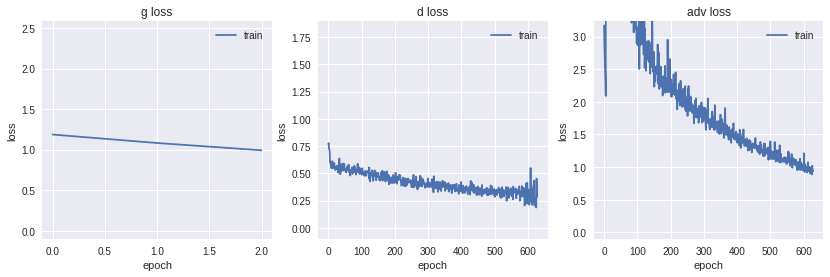

############################## epocs 1
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of the preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.387948304414

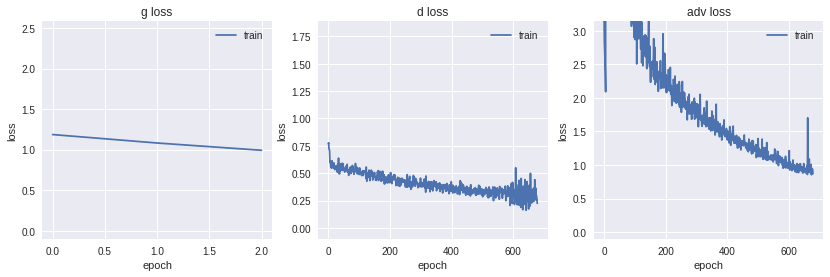

############################## epocs 2
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of the preparing the earth and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: `And the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.381029516458

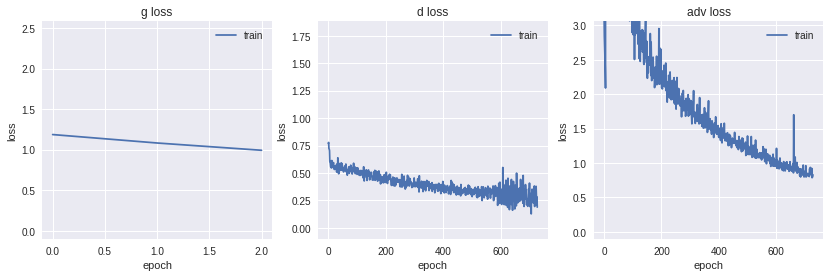

############################## epocs 3
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of the preparing the earth and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.37487858533859

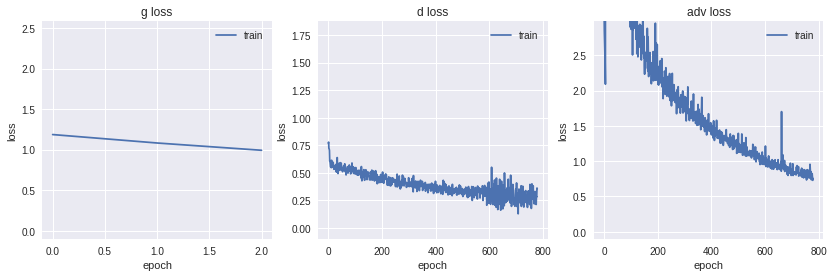

############################## epocs 4
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of the preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.368220067024

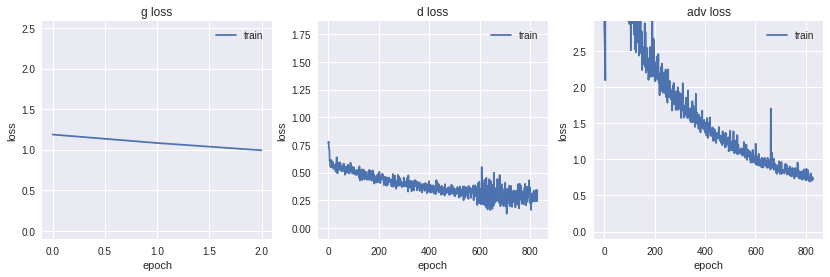

############################## epocs 5
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.3632076621

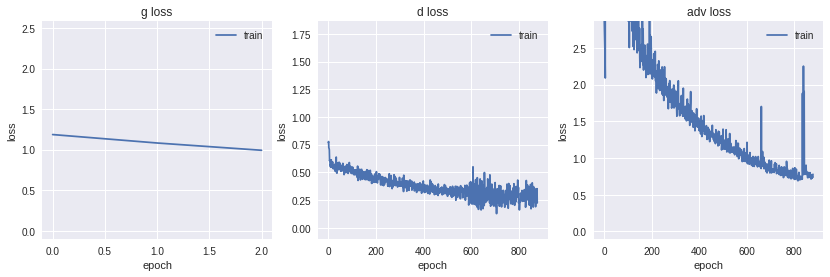

############################## epocs 6
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50
20 expect to wait a minute here on CPU... running few small steps, till 50
30 expect to wait a minute here on CPU... running few small steps, till 50
40 expect to wait a minute here on CPU... running few small steps, till 50
############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
1.0813442859649658
0.3586388945

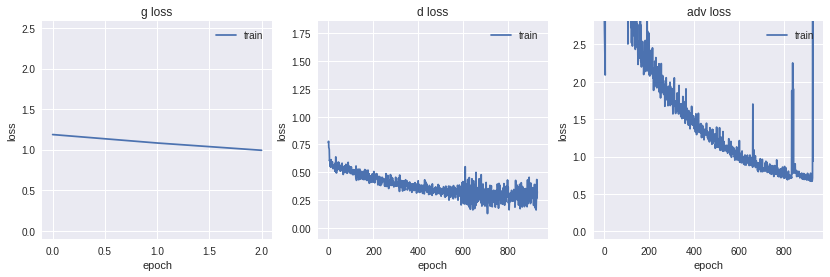

############################## epocs 7
0 expect to wait a minute here on CPU... running few small steps, till 50
10 expect to wait a minute here on CPU... running few small steps, till 50


KeyboardInterrupt: ignored

In [220]:
print ('epoc contains ',epoc,'batches of', batch_size)
small_steps=5
for e in range(50):
  print ('#'*30,'epocs',e)
  for i in range(int(epoc/small_steps)):
    if i%10 ==0:print (i,'expect to wait a minute here on CPU... running few small steps, till',int(epoc/small_steps))
    
    for j in 10: #train d until it has a reasnbile value. or enough steps passed
      train_d(d,small_steps)
      l=loss_history_d.losses['loss'][-1:][0]
      if l<0.5:
        break
      
    train_adv(adv_model,small_steps)
  show_sample('train',sample_id=[0],teacher_forcing=True)   #,8000+0
  plt_all()
print ('done')

models      = [encoder_model   , model,    decoder_sampling_model,   d_classifier_model] #rest can be built from them?  
model_names = ['encoder_model', 'model', 'decoder_sampling_model','d_classifier_model' ] #rest can be built from them?  
#Persistency().load_weights_from('models/2018-07-15_10-15-21',models,model_names)
Persistency().save_weights(models,model_names) #not run yet....


############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of God's preparing the earth and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
############################## verb 1 ##############################
encoder_input  [t_ylt.csv]: "the earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
encoder_input  [t_bbe.csv]: And the earth was waste and without form; and it was dark on the face of the <oov> and the
decoder TF     [t_bbe.csv]: "This earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
dec

# SAVE LOAD MODEL

In [0]:
class GoogleDrive():
  
  def __init__(self):
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)


  def save_to_drive(self,pathname):
    file_list = self.drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    data_from_colab=None
    for file1 in file_list:  
       if file1['title']=='data_from_colab':
          #print ('title: %s, id: %s' % (file1['title'], file1['id']))
          data_from_colab = file1['id']

    if (data_from_colab):
      f = self.drive.CreateFile({'parents':[{u'id': data_from_colab}]})
      f.SetContentFile(pathname)
      f.Upload() 
      f_id = f['id']
      print (f'saving {pathname} as id {f_id}')
      return f_id
    else:
      raise Exception('did not find')

      
  def load_from_drive(self,id_in_drive,local_pathname): #find it from share
    down= self.drive.CreateFile({'id': id_in_drive}) #{'id': '1nIcmbxc6c3Nic35O2JrSEmTmq7X6D2a2'}
    down.GetContentFile(local_pathname)   
  
  

def test():
  
  GoogleDrive()
  i=save_to_drive('language-style-transfer/LICENSE')
  load_from_drive(i,'language-style-transfer/LICENSE_OUT_2')
  !ls -l language-style-transfer
  


In [0]:

   
class Persistency():

  def save_weights(self,model,model_names,save_to_gdrive=True):
    import shutil
    from time import gmtime, strftime

    # keras can save model architecture + weights + opt_state using model.save
    # It can also sepately save weights and architecture as json
    # When using custom code (like our loss function), one need to use CustomObject (TODO)

    #we have 3 top-level-models
    # model = encoder_model + decoder_model
    # d = d_classfier_model + d_encoder_model
    # adv = encoder_model , classfier_model, decoder_model
    # but they share few of their weights
    time_str = strftime("%Y-%m-%d_%H-%M-%S", gmtime())

    models_base_dir = 'models'
    models_time_dir = f'{models_base_dir}/{time_str}/'

    if not os.path.exists(models_time_dir):
       os.makedirs(models_time_dir)


    #TODO: split part of model, decoder_sampling_model to decoder weights only
    for i in range(len(models)):
      models[i].save_weights(models_time_dir +model_names[i]+'.h5')

    !ls -lh {models_base_dir}
    shutil.make_archive(f'{models_base_dir}/models_weights_{time_str}','zip', models_time_dir) 
    !ls -lh {models_base_dir}

    if (save_to_gdrive):
      drive = GoogleDrive()
      drive.save_to_drive(f'{models_base_dir}/models_weights_{time_str}.zip')


  def load_weights_from(self,folder) :
    #id_in_drive='1Jth1h97t_M6HngZgGLP64V7OFxjvR-3x'
    #drive.load_from_drive(id_in_drive,f'{models_base_dir}/models_weights_{time_str}_OUT.zip')
    for i in range(len(models)):
      pathname = f'{folder}/{model_names[i]}.h5'
      if not os.path.exists(pathname):
        print (pathname,'missing. breaking!')
        return
      else:
        print ('loading',pathname)
      models[i].load_weights(pathname)
    print ('load from ',folder,'complete. Make sure you already compiled the model and set optimizers')

    
#models      = [encoder_model   , model,    decoder_sampling_model,   d_classifier_model] #rest can be built from them?  
#model_names = ['encoder_model', 'model', 'decoder_sampling_model','d_classifier_model' ] #rest can be built from them?  
#Persistency().load_weights_from('models/2018-07-15_10-15-21',models,model_names)
  




In [163]:
!ls models/2018-07-15_10-15-21

d_classifier_model.h5  decoder_sampling_model.h5  encoder_model.h5  model.h5


# Error analysis

In [246]:
show_sample('train',sample_id=[0,1,2,999],teacher_forcing=False)   #,8000+0
print (' VAL '*10)
show_sample('val'  ,sample_id=[0,1,2,999],teacher_forcing=False)   #,8000+0

# VAL SO BAD , TOO MUCH OVERFIT . NOT ENOUGH DATA g0.5/2.5


############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder sample [t_bbe.csv]: In the memory of our God, the heavens and the earth full." <s>
decoder sample [t_ylt.csv]: In the beginning of our God, the heavens and the earth -- <s>
############################## verb 1 ##############################
encoder_input  [t_ylt.csv]: "the earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
encoder_input  [t_bbe.csv]: And the earth was waste and without <oov> and it was dark on the face of the <oov> and the
decoder sample [t_bbe.csv]: The earth has <oov> waste and <oov> and light night on the dust of the name of the earth and still
decoder sample [t_ylt.csv]: "the earth hath <oov> waste and <oov> a

In [287]:



#a= model.predict([x_train[s:e], x_train_d[s:e]])
#for i in range(dataset.MAX_SEQUENCE_LENGTH):
#  best=np.argmax(a[0,i])
#  print (i,best,dataset.index2word[best],a[0,i,best],a[0,i,0])

#NEED TO FIX CODE HERE
from keras.losses import categorical_crossentropy
p=model.predict([x_val,x_val_d])
scores=K.eval(K.sum(categorical_crossentropy(K.constant(p), K.constant(y_val) ),axis=1))
worse_10 = scores.argsort()[::-1][:10]

for i in range(len(worse_10)):
  bad=worse_10[i]
  print (i,'arg',bad,'score',scores[bad],show_sample('val',False,bad))
  


ValueError: ignored

## Error of style disc.

In [211]:
### Error of style discriminator
x,y=next(gen(dataset.result.val,10,'d'))
print ('eval',d.evaluate(x,y))
p=d.predict(x)
for i in range(len(y)):
  print (i,'error',(abs(y[i][0]-p[i][0])),'gold',y[i],p[i],dataset.one_x_as_text(x[i]))





10/10 [==============================] - 0s 2ms/step
eval [0.6257959008216858, 0.8999999761581421]
0 actual 0.38546136 [0. 1.] [0.38546136 0.6145386 ] For I have kept the ways of the Lord; I have not been turned away in sin from my God.
1 actual 0.42803007 [0. 1.] [0.42803007 0.5719699 ] "And while she was still talking with the king, <oov> the prophet came in." <s> <s> <s> <s> <s> <s>
2 actual 0.31531385 [0. 1.] [0.31531385 0.6846862 ] "Then he gave a cry to the servant who was waiting on him and said, Put this woman out, and
3 actual 0.01998341 [1. 0.] [0.9800166  0.01998337] "And all the people come up after him, and the people are <oov> with <oov> and <oov> -- great joy,
4 actual 0.116271734 [0. 1.] [0.11627173 0.8837283 ] "Now the servants of David and <oov> had been out attacking a band of armed men, and they came back
5 actual 0.10636711 [0. 1.] [0.10636711 0.8936329 ] "He made them of liquid metal in the lowland of Jordan, at the way across the river, at <oov> between
6 actual 

# FAQ and wierd exceptions

* If you get exceptions related to cuda-lstm , inside the show_sample, but you actially not using it at all.  You will need to restart the notebook (thinking it's TF issue/bug)

In [53]:
# If d not training (accuracy close to 0.5): check this. from som reason, it is not trainlable
# solution is to recompile, and redefine train_d . TODO: find source of problem
#  Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
#  'Discrepancy between trainable weights and collected trainable'
def print_d_mean():
  print(d.get_layer('d__dense_softmax').get_weights()[0].mean(),'b',d.get_layer('d__dense_softmax').get_weights()[1].mean())
print_d_mean()






-0.0030405987 b 0.0
(len(d.trainable_weights)) 4
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f416565b320> False {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}
embedding_7 <keras.layers.embeddings.Embedding object at 0x7f416565bc88> False {'name': 'embedding_7', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
bidirectional_7 <keras.layers.wrappers.Bidirectional object at 0x7f41656c9588> False {'name': 'bidirectional_7', 'trainable': False, 'layer': {'class_name': 'CuDNNLSTM', 'config': {'name': 'cu_dnnlstm_13', 'trainable': True, 'return_sequences': False, 'return_state': True, 'go_backwards': False, 'sta

100/100 [==============================] - 3s 30ms/step - loss: 8.1245 - acc: 0.4959 - val_loss: 7.0517 - val_acc: 0.5625
-0.0030405987 b 0.0
g
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/50 [==============================] - 8s 161ms/step - loss: 4.9978 - val_loss: 5.0033
-0.0030405987 b 0.0
Epoch 1/1
100/100 [==============================] - 4s 37ms/step - loss: 8.0288 - acc: 0.5019 - val_loss: 7.3035 - val_acc: 0.5469
-0.0030405987 b 0.0
(len(d.trainable_weights)) 4


0.0032313007 b 1.3737008e-08
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f40b60c1080> False {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}
model_106 <keras.engine.training.Model object at 0x7f40b5e6b240> False {'name': 'model_106', 'layers': [{'name': 'encoder_inputs', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}, 'inbound_nodes': []}, {'name': 'embedding_14', 'class_name': 'Embedding', 'config': {'name': 'embedding_14', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}, 'inbound_nodes': [[['encoder_inputs', 0, 0, {}

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


150/150 [==============================] - 5s 34ms/step - loss: 8.0003 - acc: 0.5036 - val_loss: 6.5480 - val_acc: 0.5938
0.0032313007 b 1.3737008e-08


False trainable 0 11
True trainable 4 7


2
<keras.engine.topology.InputLayer object at 0x7f40b7b04da0> False
<keras.layers.core.Dense object at 0x7f40b7b04e10> True
<keras.engine.topology.InputLayer object at 0x7f40b7b04da0> False
<keras.layers.core.Dense object at 0x7f40b7b04e10> False


3